In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from util_data_pixels import *
from amorgibbs_v import *
from smc_v import *
from util_plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
sys.path.append('/home/hao/Research/probtorch/')
from probtorch.util import expand_inputs
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [6]:
## Dataset parameters
T = 30
K = 4
D = 2
dt = 6
Boundary = 32
radius =0.5
noise_ratio = 0.5
num_seq = 200
## image paramters
pixels = 64
dpi = 200
radius = 3

## Model Parameters
num_particles_rws = 30
mcmc_steps = 3
num_particles_smc = 30
NUM_HIDDEN = 256
NUM_LATENTS = K*K
NUM_OBS = 2 * K
## VAE
num_particles_rws_outer = 5
NUM_PIXELS = 64*64
NUM_LATENT = 2 
NUM_SAMPLES = 1
EPS = 1e-9
ALPHA = 0.1
BETA = (2.0, 2.0, 1.0, 0.0, 1.0) 
BATCH_SIZE = T+1

NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_Amor_ENC = "experiment/pixels_enc-%drwsvae-%drws-%dmcmc-%dsmc-enc" % (num_particles_rws_outer, num_particles_rws, mcmc_steps, num_particles_smc)
PATH_ENC = "highvarprior-pretrained-vae-enc"
PATH_DEC = "highvarprior-pretrained-vae-dec"

In [7]:
## return samples in order to compute the weights and 
class Amor_Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden)).sum(0).view(K, K)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples
## VAE
class Encoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_latent=NUM_LATENT):
        super(self.__class__, self).__init__()

        self.enc_hidden = nn.Sequential( 
                            nn.Linear(num_pixels, num_hidden),
                            nn.ReLU(),
                            nn.Linear(num_hidden, num_hidden),
                            nn.ReLU())
        
        self.z_mean = nn.Linear(num_hidden, num_latent)
        self.z_log_std = nn.Linear(num_hidden, num_latent)
    @expand_inputs
    def forward(self, images, labels=None, num_samples=NUM_SAMPLES):
        q = probtorch.Trace()
        hiddens = self.enc_hidden(images)
        q.normal(self.z_mean(hiddens),
                 self.z_log_std(hiddens).exp(),
                 name='z')
        return q
    
def binary_cross_entropy(x_mean, x, EPS=1e-9):
    return - (torch.log(x_mean + EPS) * x + 
              torch.log(1 - x_mean + EPS) * (1 - x)).sum(-1)

class Decoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_latent=NUM_LATENT):
        super(self.__class__, self).__init__()
        
        self.dec_image = nn.Sequential(
                           nn.Linear(num_latent, num_hidden),
                           nn.ReLU(),
                           nn.Linear(num_hidden, num_pixels),
                           nn.Sigmoid())

    def forward(self, images, q=None, num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE, num_latent=NUM_LATENT):
        p = probtorch.Trace()
        z_mean = torch.zeros(num_samples, batch_size, num_latent)
        z_std = torch.ones(num_samples, batch_size, num_latent)*210
        
        if CUDA:
            z_mean = z_mean.cuda()
            z_std = z_std.cuda()
        
        z = p.normal(z_mean, 
                     z_std,
                     value=q['z'],
                     name='z')
        
        images_mean = self.dec_image(z)
        p.loss(binary_cross_entropy, images_mean, images, name='images')
        return p

In [8]:
def initialize():
    amor_enc = Amor_Encoder()
    enc = Encoder()
    dec = Decoder()
    
    enc.load_state_dict(torch.load(PATH_ENC))
    dec.load_state_dict(torch.load(PATH_DEC))
    optimizer =  torch.optim.Adam(list(enc.parameters())+list(amor_enc.parameters()),lr=LEARNING_RATE)    
    return amor_enc, enc, dec, optimizer
amor_enc, enc, dec, optimizer = initialize()

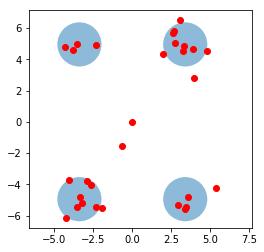

In [9]:
init_v = init_velocity(dt)
alpha_trans_0 = initial_trans_prior(K)
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio
STATE, mu_ks, cov_ks, Pi, Y_true, A_true, Zs_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov, radius)
generate_frames(STATE, Boundary, pixels, dpi, radius, 0)    
X_imgs = sample_pixels(T, pixels, 0).view(-1, NUM_PIXELS)
q = enc(X_imgs,num_samples=NUM_SAMPLES)
p = dec(X_imgs, q, num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE)
z_means = q['z'].dist.mean.detach().squeeze(0).data.numpy()

coor = q['z'].value.squeeze(0)
Y = coor[1:] - coor[:-1]
cov_true = np.tile(noise_cov, (K, 1, 1))
dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
plot_clusters(Y_true.data.numpy(), mu_true, cov_true, K)

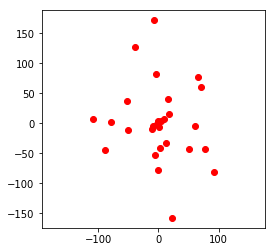

In [10]:
plot_clusters(Y.detach().data.numpy(), mu_true, cov_true, K)

In [ ]:
KLs = []
EUBOs = []
LOG_Qs = []
ESSs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    #     T = np.random.randint(T_min, T_max)
    init_v = init_velocity(dt)
    alpha_trans_0 = initial_trans_prior(necessarily the case. We just need to
understand that observe and sample expressions affK)
    noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov, radius)
    generate_frames(STATE, Boundary, pixels, dpi, radius, epoch)    
    X_imgs = sample_pixels(T, pixels, epoch).view(-1, NUM_PIXELS)
    log_weights = torch.zeros((num_particles_rws_outer, num_particles_rws))
    loss_infer = torch.zeros((num_particles_rws_outer, num_particles_rws))
    klss = torch.zeros((num_particles_rws_outer, num_particles_rws))
    eubos = torch.zeros((num_particles_rws_outer, num_particles_rws))
    for r in range(num_particles_rws_outer):
        q = enc(X_imgs,num_samples=NUM_SAMPLES)
        p = dec(X_imgs, q, num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE)
        coor = q['z'].value.squeeze(0)
        Y = coor[1:] - coor[:-1]
        cov_true = np.tile(noise_cov, (K, 1, 1))
        dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
        mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
        plot_clusters(Y.detach().data.numpy(), mu_true, cov_true, K)
        
        amor_enc, log_weight_rwss, log_p_smcss, log_qs, log_p_joints, kls = rws_pixels(amor_enc, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles_rws, num_particles_smc, mcmc_steps)
    #     p.log_joint() - q.log_joint() # + incremental weight - log_smc_joint - log_q_amorNN
        log_weights[r] = (p['images'].log_prob.sum() - q['z'].log_prob.sum() + log_weight_rwss - log_p_smcss - log_qs).detach()
        eubos[r] = (p['images'].log_prob.sum() - q['z'].log_prob.sum() + log_weight_rwss + log_p_joints - log_p_smcss - log_qs).detach()
        loss_infer[r] = - log_qs - q['z'].log_prob.sum()
        klss[r] = kls
        
    log_weights = log_weights.view(1, num_particles_rws_outer * num_particles_rws)
    loss_infer = loss_infer.view(1, num_particles_rws_outer * num_particles_rws)
    eubos = eubos.view(1, num_particles_rws_outer * num_particles_rws)
    weights = torch.exp(log_weights - logsumexp(log_weights, dim=0))
    ess = (1. / (weights ** 2 ).sum()).item()
    klss = klss.view(1, num_particles_rws_outer * num_particles_rws)
    Loss = torch.mul(weights, loss_infer).sum()
    KL = torch.mul(weights, klss).sum().item()
    eubo = torch.mul(weights, eubos).sum().item()

    Loss.backward()
    KLs.append(KL)
    EUBOs.append(eubo)
    ESSs.append(ess)
    LOG_Qs.append(-Loss.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, log_q : %f, KL : %f (%ds)' % (epoch, eubo, -Loss.item(), KL, time_end - time_start))

In [ ]:
plot_dirs(enc, alpha_trans_0, Z_ret, Zs_true, T, K, num_particles_rws, vmax=15)

In [ ]:
plot_results(EUBOs, log_qs, KLs, ESSs, num_particles_rws)

In [ ]:
if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)

In [ ]:
mu_true

In [ ]:
cov_true